In [546]:
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pylab import rcParams


warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(15, 7)})
sns.set_style('white')
pd.set_option('display.max_columns', 500)

###### Time Series Analysis

In [627]:
housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')

df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
df.rename(columns={'SalePrice': 'Observed'}, inplace=True)

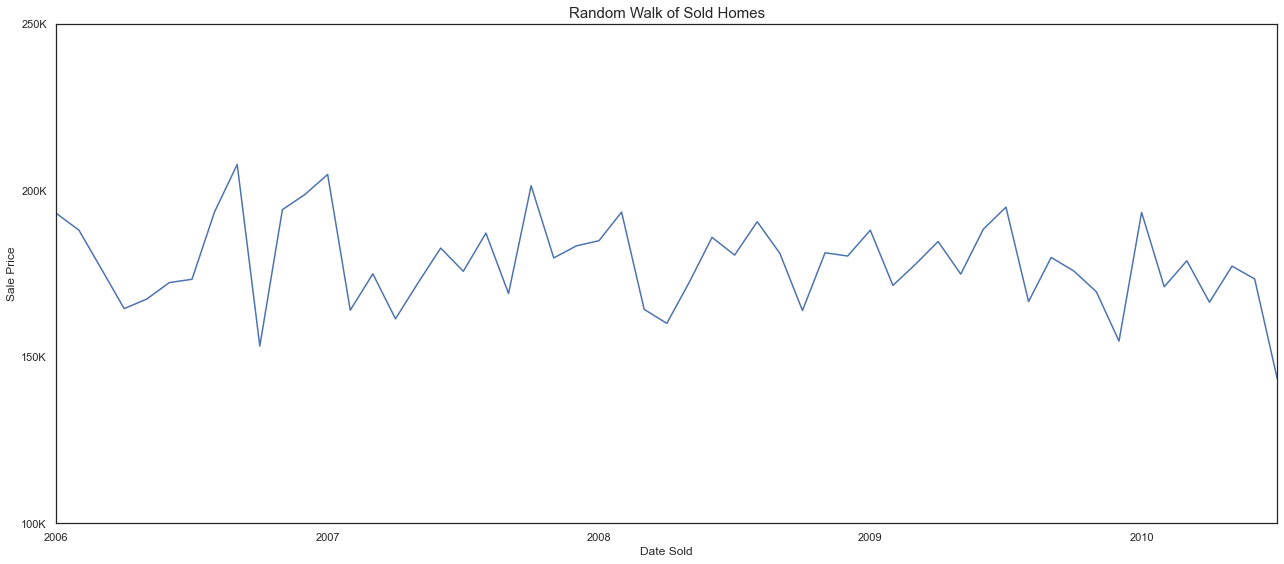

In [628]:
fig = df.plot(legend=False)
fig.set(xlabel='Date Sold',
        ylabel='Sale Price',
        xticks=['2006-01', '2007-01', '2008-01', '2009-01', '2010-01'],
        xticklabels=list(range(2006, 2011)),
        yticks=[1e5, 1.5e5, 2e5, 2.5e5],
        yticklabels=['100K', '150K', '200K', '250K'])
plt.title('Random Walk of Sold Homes', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Timeseries DateSold, Lineplot.png', dpi = 1000)
plt.show()

In [629]:
adf = sm.tsa.adfuller(df, regression='ct')
print(f'adf test: {adf[0]}, p-value: {adf[1]}')

# looks like we can reject the null hypothesis and continue with the test

adf test: -6.948276068898889, p-value: 1.8493823638383215e-08


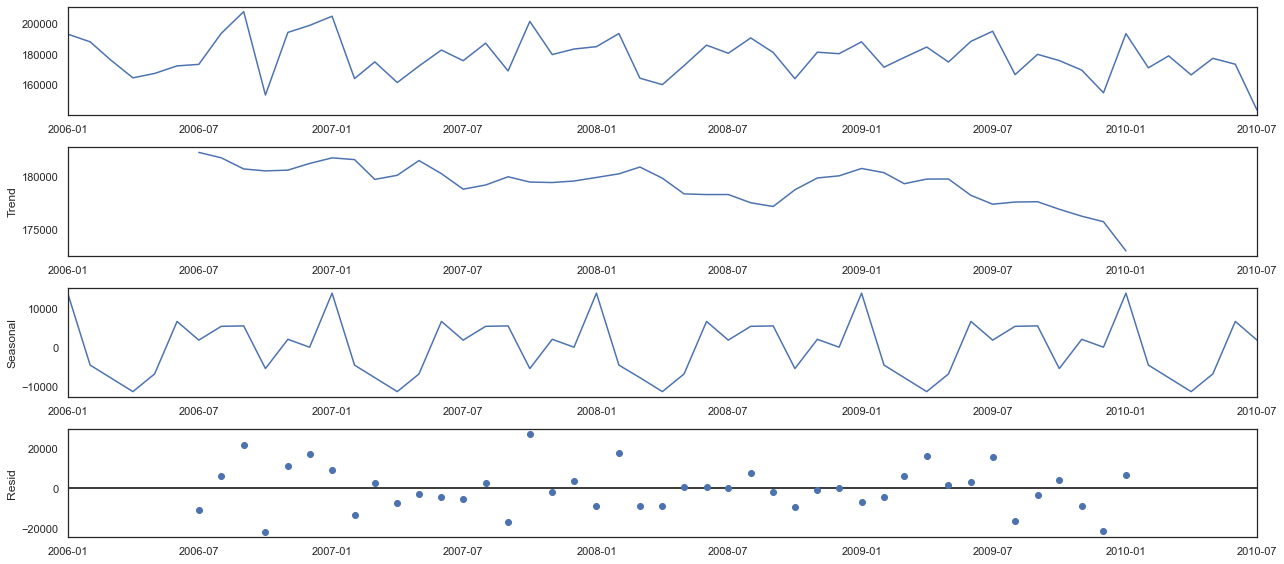

In [630]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=12)
fig = decomposition.plot()
plt.show()

# there's a clear trend downwards -- this is probably due to the housing crisis
# we can also clearly see a seasonality trend
# residuals all look normalized, for the most part

In [631]:
# lets find the best parameters with the lowest AIC score and lowest MSE

optimal_sarima = 1e6
pdq = []
seasonal_pdq = []

for arima, sarima, aic in results:
    if aic < optimal_sarima:
        optimal_sarima = aic
        pdq = arima
        seasonal_pdq = sarima
    else:
        continue
        
print(f'arima: {pdq}, sarima: {seasonal_pdq}, AIC: {optimal_sarima}')

arima: (0, 1, 1), sarima: (0, 1, 1, 10), AIC: 359.245901225305


In [632]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
result = mod.fit(disp=False)
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5887      0.528     -1.116      0.265      -1.623       0.445
ma.L1          0.0422      0.597      0.071      0.944      -1.128       1.212
ar.S.L12      -0.5997      0.361     -1.662      0.097      -1.307       0.108
sigma2      3.357e+08   9.01e-10   3.72e+17      0.000    3.36e+08    3.36e+08


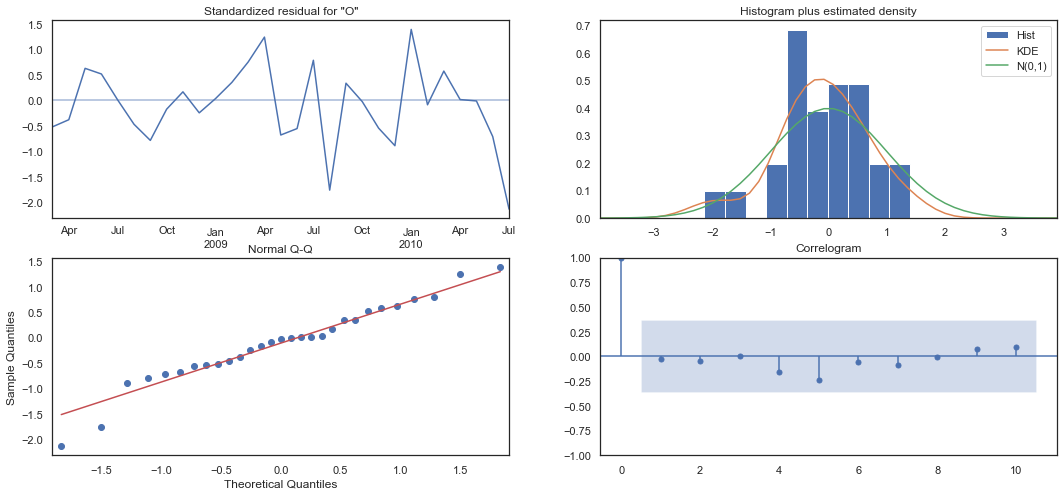

In [633]:
result.plot_diagnostics()
plt.show()

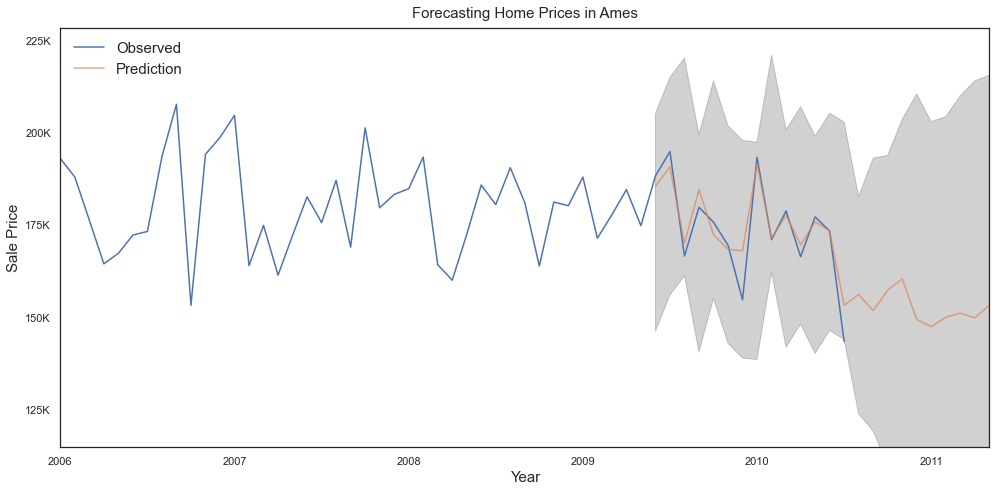

In [634]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
result = mod.fit(disp=False)

predict = result.get_prediction(start=pd.to_datetime('2009-06-01'), dynamic=False)
forecast = result.get_forecast(steps=10)

forecast_dates = pd.date_range(predict.predicted_mean.index[len(predict.predicted_mean)-1], 
                  freq='MS', periods=len(forecast.predicted_mean)).shift(1)

ci = predict.conf_int().append(forecast.conf_int().set_axis(forecast_dates))
pred = predict.predicted_mean.append(forecast.predicted_mean.set_axis(forecast_dates))
fig = df.plot(label='Observed')

predicted_mean = pred.shift(-1)
predicted_mean.iloc[len(predicted_mean)-1] = result.forecast(1)
predicted_mean.plot(ax=fig, label='Prediction', alpha=.7, figsize=(14, 7))

fig.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k', alpha=.2)

fig.set(ylim = (min(df['Observed']) - 0.2*min(df['Observed']), 
                max(df['Observed']) + 0.1*max(df['Observed'])),
        yticks = [1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5],
        yticklabels = ['125K', '150K', '175K', '200K', '225K'])

plt.title('Forecasting Home Prices in Ames', fontsize = 15, pad=10)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.legend(frameon=False, prop={'size': 15}, loc='upper left')
plt.tight_layout()
plt.savefig(f'./visualizations/ames_sarima_prediction.png', dpi = 600)
plt.show()

### Grid Search for Neighborhoods

In [601]:
neighborhoods = ['SWISU', 'Edwards', 'IDOTRR', 'OldTown', 'NWAmes', 
                 'Mitchel', 'NridgHt', 'NAmes', 'CollgCr', 'SawyerW', 
                 'Gilbert', 'Timber', 'Somerst', 'BrkSide', 'NoRidge',
                 'Sawyer', 'Crawfor', 'ClearCr', 'StoneBr']

not_enough_data = ['Veenker', 'NPkVill', 'Blueste', 'Greens', 
                   'MeadowV', 'BrDale', 'Blmngtn']

In [540]:
for neighborhood in neighborhoods:

    housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
    housing = housing[housing['Neighborhood'] == neighborhood]
    DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                            housing['MoSold'].astype(str) + '-1').rename('DateSold')

    df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
    df.rename(columns={'SalePrice': 'Observed'}, inplace=True)

    adf = sm.tsa.adfuller(df)
    print(f'{neighborhood} adf test: {adf[0]}, p-value: {adf[1]}')
    
# Gilbert and StoneBr requires additional differencing

SWISU adf test: -3.7592383129809224, p-value: 0.0033530035245061627
Edwards adf test: -6.071271131006947, p-value: 1.149312467617462e-07
IDOTRR adf test: -5.757669323828819, p-value: 5.769119927537924e-07
OldTown adf test: -7.887470560579446, p-value: 4.52913486135848e-12
NWAmes adf test: -6.727541913811171, p-value: 3.3598191675201534e-09
Mitchel adf test: -6.403153916768839, p-value: 1.9726615506508446e-08
NridgHt adf test: -6.865715875922615, p-value: 1.5610735361637755e-09
NAmes adf test: -7.741994134294114, p-value: 1.0559034516910614e-11
CollgCr adf test: -6.7469642556441585, p-value: 3.017922232004265e-09
SawyerW adf test: -4.1104475143417245, p-value: 0.0009307213270653775
Gilbert adf test: -3.211768517419337, p-value: 0.01931349769456237
Timber adf test: -5.323395987732451, p-value: 4.896582824883232e-06
Somerst adf test: -7.585924322617158, p-value: 2.60694254017778e-11
BrkSide adf test: -7.707976148827093, p-value: 1.2863311432302925e-11
NoRidge adf test: -5.507526451016945,

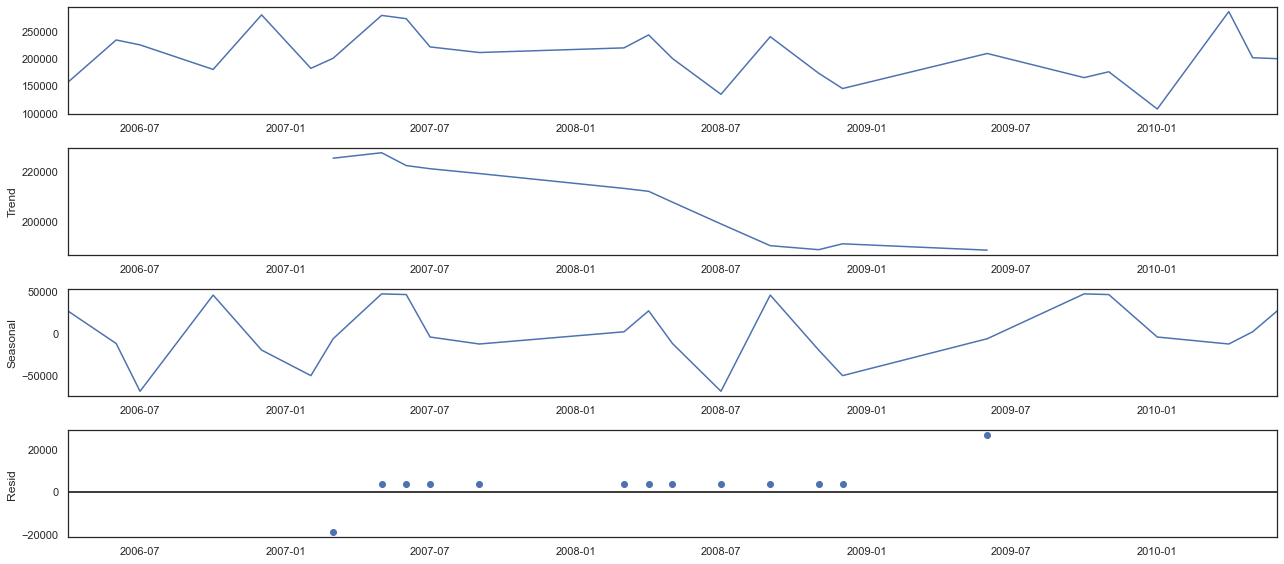

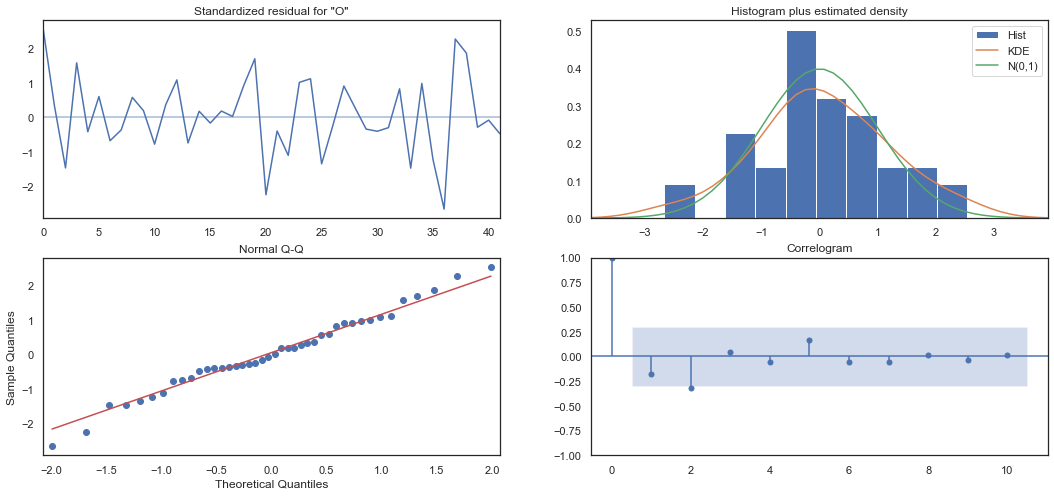

In [527]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=12)
fig = decomposition.plot()
plt.show()

result.plot_diagnostics()
plt.show()

In [541]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 10) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[4]}')

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 10)
SARIMAX: (0, 0, 1) x (0, 1, 0, 10)
SARIMAX: (0, 1, 0) x (0, 1, 1, 10)
SARIMAX: (0, 1, 0) x (1, 0, 0, 10)


In [606]:
neighborhood_params = {
    'SWISU': [(1, 1, 1), (1, 0, 1, 4), True, True, '2009-07-01',
             [6e4, 8e4, 1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5, 2e5],
             ['60K', '80K', '100K', '120K', '140K', '160K', '180K', '200K']],
    'Edwards': [(0, 1, 0), (1, 1, 1, 8), True, True, '2009-07-01',
               [5e4, 1e5, 1.5e5, 2e5, 2.5e5, 3e5],
               ['50K', '100K', '150K', '200K', '250K', '300K']],
    'IDOTRR': [(1, 0, 0), (1, 0, 1, 10), True, True, '2009-07-01',
              [5e4, 7.5e4, 1e5, 1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5],
              ['50K', '75K', '100K', '125K', '150K', '175K', '200K', '225K']],
    'OldTown': [(1, 1, 0), (1, 0, 1, 8), True, True, '2009-07-01',
               [8e4, 1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5],
               ['80K', '100K', '120K', '140K', '160K', '180K']],
    'NWAmes': [(1, 1, 0), (1, 0, 0, 10), True, False, '2009-07-01',
              [1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5, 2.75e5, 3e5],
              ['125K', '150K', '175K', '200K', '225K', '250K', '275K', '300K']],
    'Mitchel': [(1, 0, 0), (0, 0, 1, 10), True, True, '2009-07-01',
                [1e5, 1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5], 
                ['100K', '125K', '150K', '175K', '200K', '225K', '250K']],
    'NridgHt': [(1, 0, 0), (1, 0, 1, 11), True, False, '2009-07-01',
               [2e5, 2.5e5, 3e5, 3.5e5, 4e5, 4.5e5],
               ['200K', '250K', '300K', '350K', '400K', '450K']],
    'NAmes': [(0, 1, 0), (1, 1, 0, 12), False, False, '2009-07-01',
             [1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5],
             ['100K', '120K', '140K', '160K', '180K']],
    'CollgCr': [(0, 1, 1), (0, 1, 1, 12), True, True, '2009-07-01',
               [1.25e5, 1.75e5, 2.25e5, 2.75e5, 3.25e5],
               ['125K', '175K', '225K', '275K', '325K']],
    'SawyerW': [(0, 1, 0), (0, 1, 0, 8), True, True, '2009-07-01',
               [1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5, 2.75e5],
               ['125K', '150K', '175K', '200K', '225K', '250K', '275K']],
    'Gilbert': [(0, 1, 0), (0, 1, 1, 10), True, True, '2009-07-01',
               [1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5, 2.75e5, 3e5],
               ['125K', '150K', '175K', '200K', '225K', '250K', '275K', '300K']],
    'Timber': [(1, 1, 0), (1, 0, 1, 12), True, True, '2009-07-01',
              [1.5e5, 2e5, 2.5e5, 3e5, 3.5e5, 4e5, 4.5e5],
              ['150K', '200K', '250K', '300K', '350K', '400K', '450K']],
    'Somerst': [(0, 1, 0), (0, 0, 1, 10), True, True, '2009-07-01',
               [1.5e5, 2e5, 2.5e5, 3e5, 3.5e5, 4e5, 4.5e5],
               ['150K', '200K', '250K', '300K', '350K', '400K', '450K']],
    'BrkSide': [(0, 1, 0), (1, 0, 1, 12), False, True, '2009-07-01',
               [4e4, 6e4, 8e4, 1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5],
               ['40K', '60K', '80K', '100K', '120K', '140K', '160K', '180K']],
    'NoRidge': [(1, 1, 0), (1, 0, 0, 11), False, True, '2009-07-01',
               [2.5e5, 3e5, 3.5e5, 4e5, 4.5e5, 5e5, 5.5e5, 6e5],
               ['250K', '300K', '350K', '400K', '450K', '500K', '550K', '600K']],
    'Sawyer': [(0, 1, 1), (0, 0, 1, 8), True, False, '2009-07-01',
              [6e4, 8e4, 1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5, 2e5],
              ['60K', '80K', '100K', '120K', '140K', '160K', '180K', '200K']],
    'Crawfor': [(0, 1, 0), (0, 0, 1, 9), True, True, '2009-07-01',
               [1.25e5, 1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5, 2.75e5, 3e5, 3.25e5],
               ['125K', '150K', '175K', '200K', '225K', '250K', '275K', '300K', '325K']],
    'ClearCr': [(0, 1, 0), (0, 0, 1, 10), False, False, '2009-06-01',
               [1e5, 1.5e5, 2e5, 2.5e5, 3e5],
               ['100K', '150K', '200K', '250K', '300K']],
    'StoneBr': [(0, 1, 0), (0, 0, 1, 9), True, False, '2009-07-01',
               [2e5, 3e5, 4e5, 5e5, 6e5],
               ['200K', '300K','400K', '500K', '600K']],
    'Veenker': [[1.5e5, 2e5, 2.5e5, 3e5, 3.5e5, 4e5], 
                ['150K', '200K', '250K', '300K', '350K', '400K']],
    'NPkVill': [[1.2e5, 1.3e5, 1.4e5, 1.5e5, 1.6e5], 
                ['120K', '130K', '140K', '150K', '160K']],
    'Blueste': [[1.2e5, 1.4e5, 1.6e5, 1.8e5, 2e5], 
                ['120K', '140K', '160K', '180K', '200K']],
    'Greens': [[1.5e5, 1.75e5, 2e5, 2.25e5], 
               ['150K', '175K', '200K' ,'225K']],
    'MeadowV': [[5e4, 7.5e4, 1e5, 1.25e5, 1.5e5], 
                ['50K', '75K', '100K', '125K', '150K']],
    'BrDale': [[8e4, 1e5, 1.2e5, 1.4e5], 
               ['80K', '100K', '120K', '140K']],
    'Blmngtn': [[1.5e5, 1.75e5, 2e5, 2.25e5, 2.5e5], 
                ['150K', '175K', '200K', '225K', '250K']]
    }

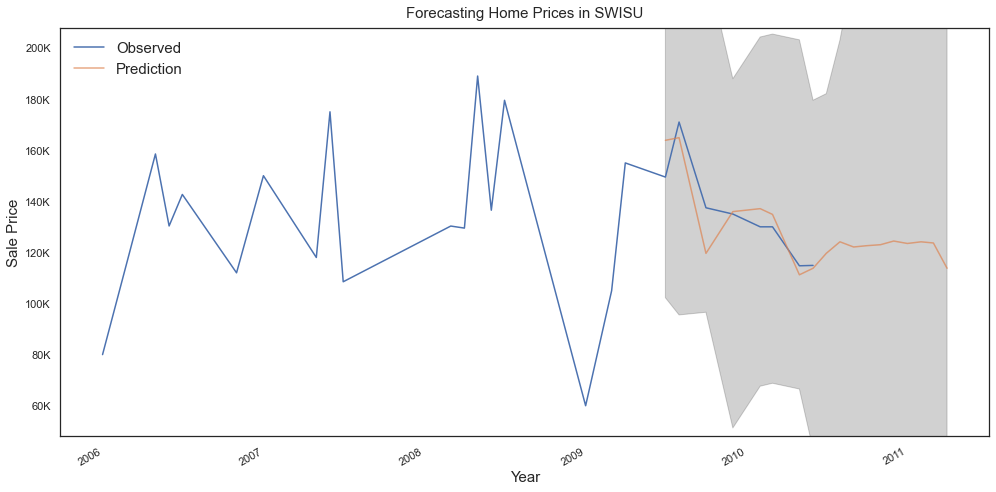

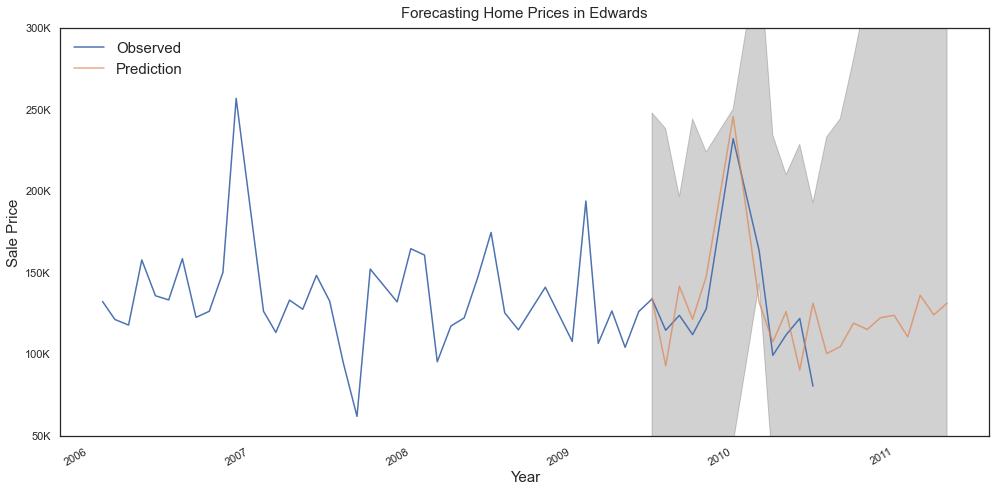

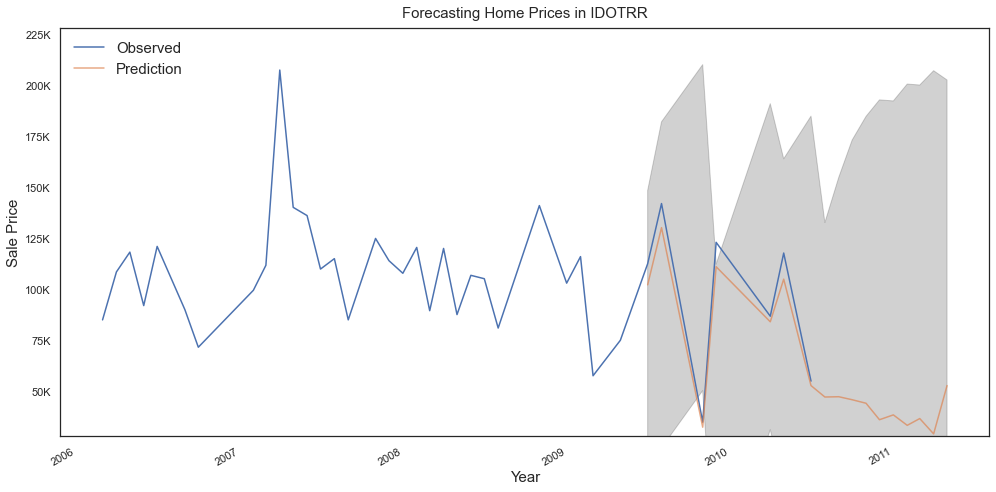

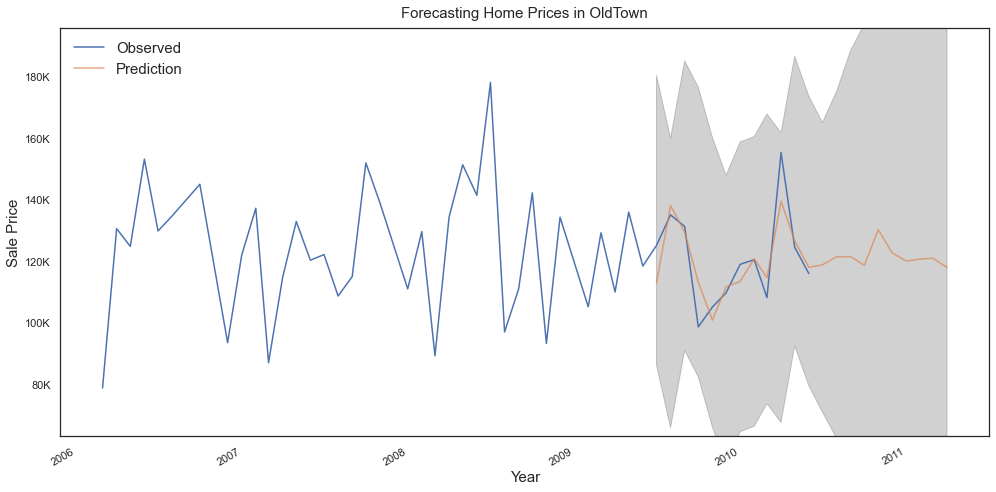

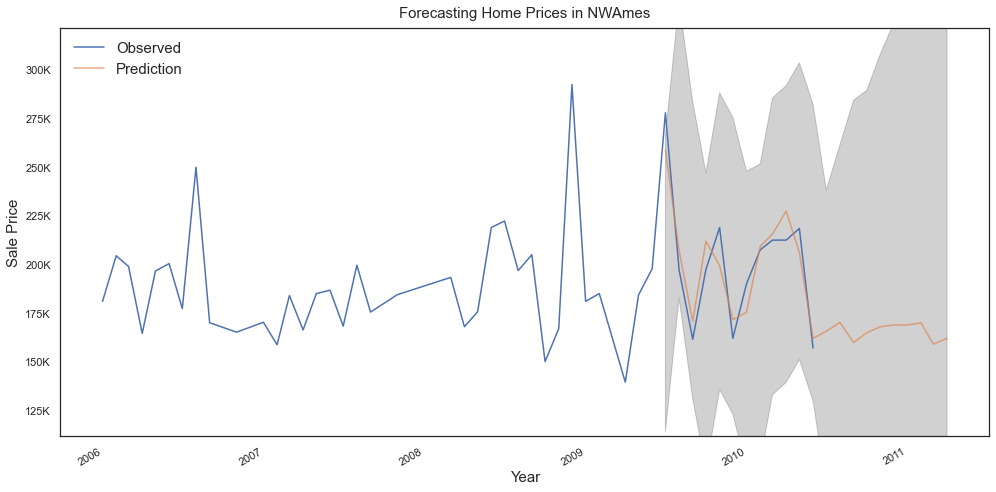

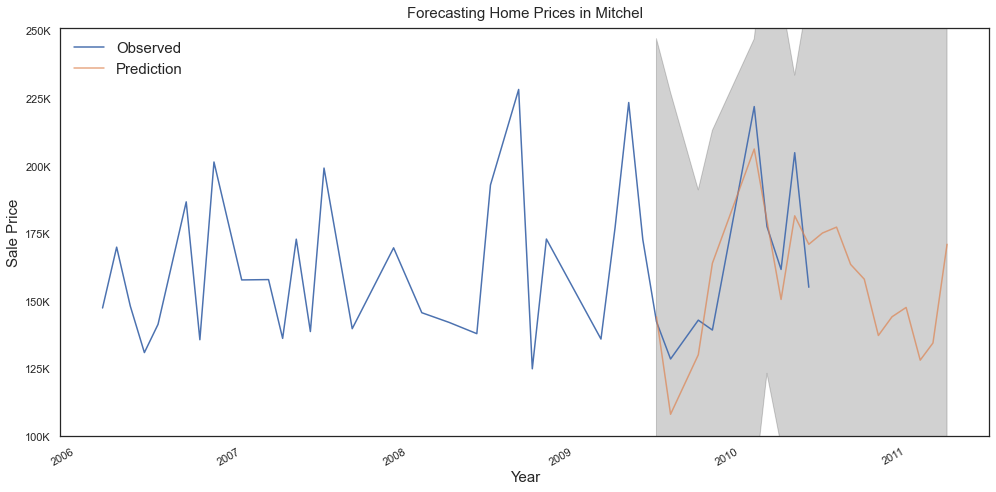

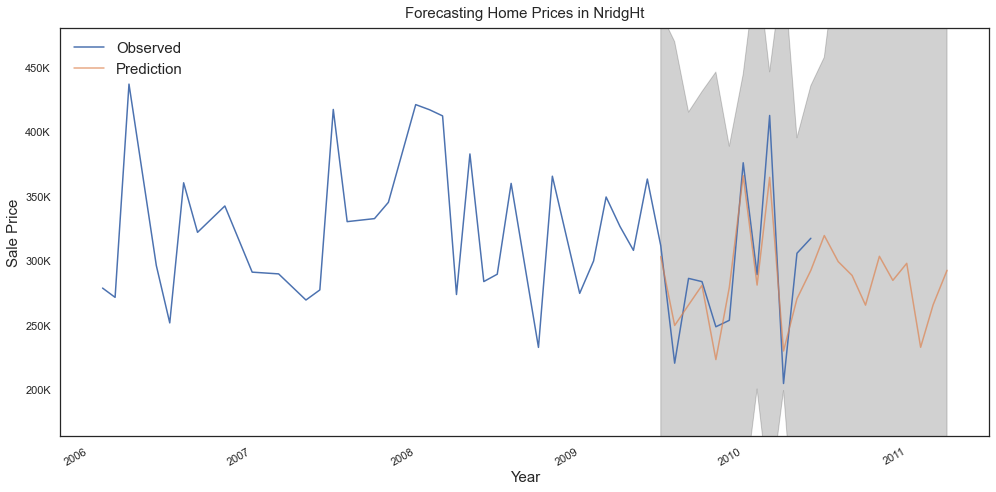

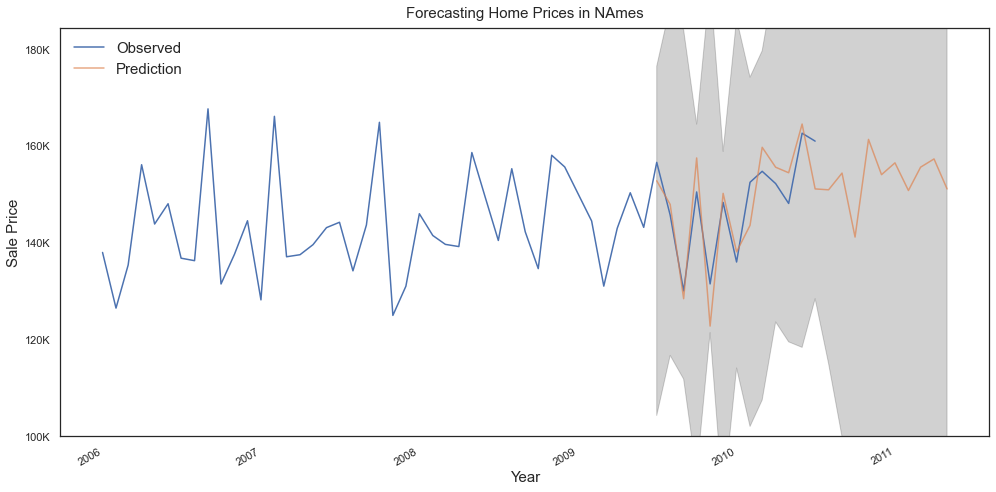

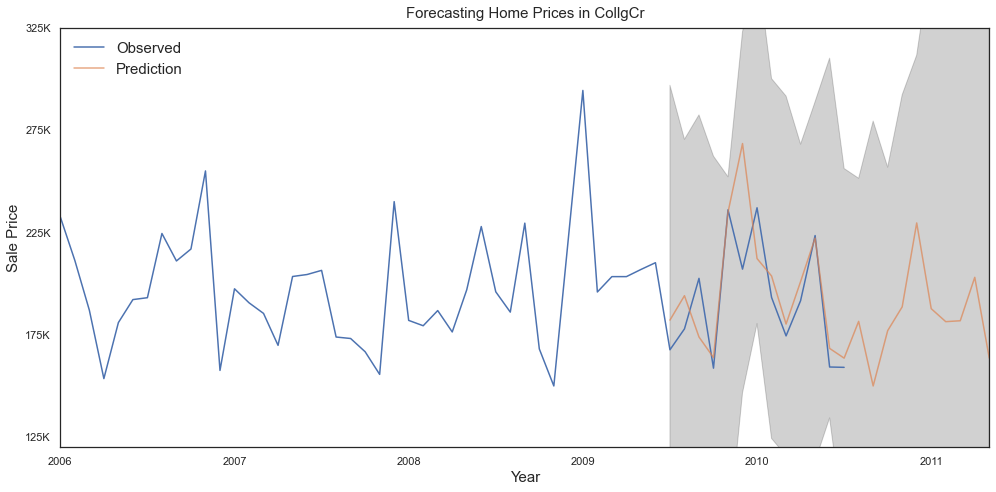

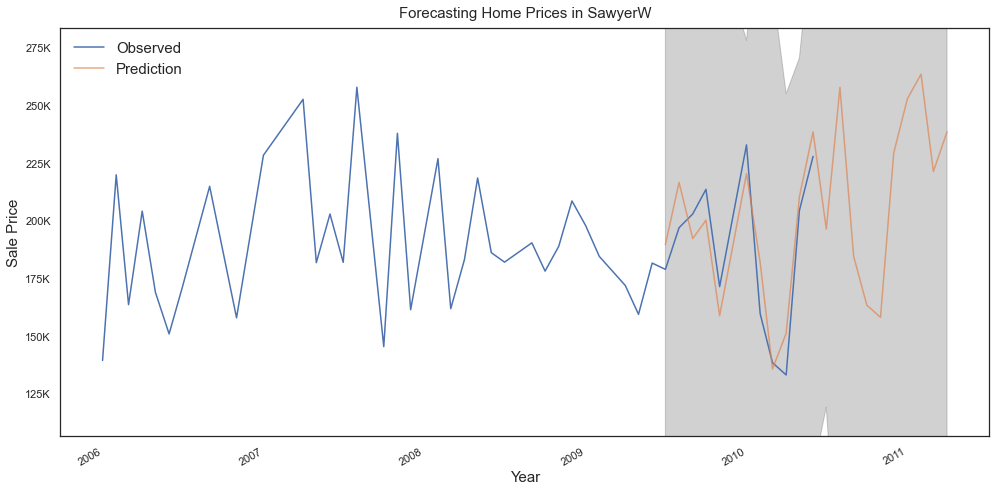

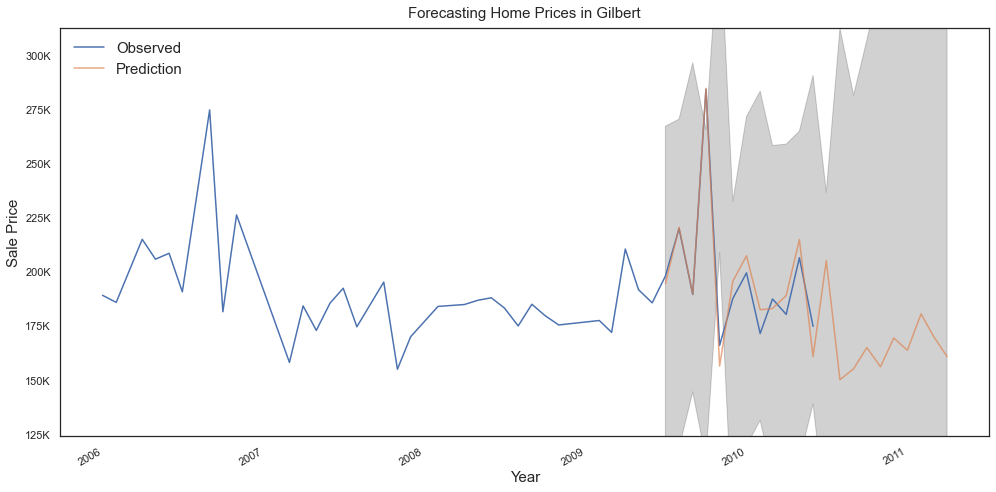

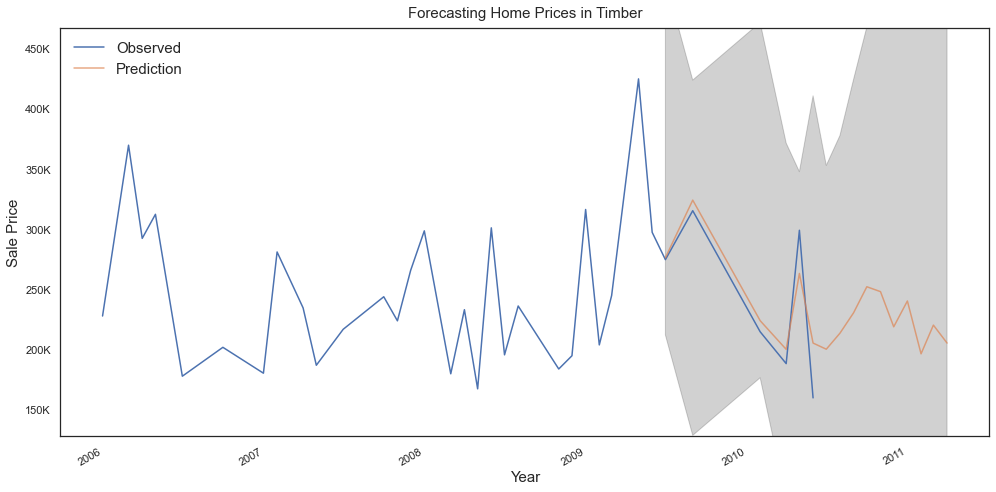

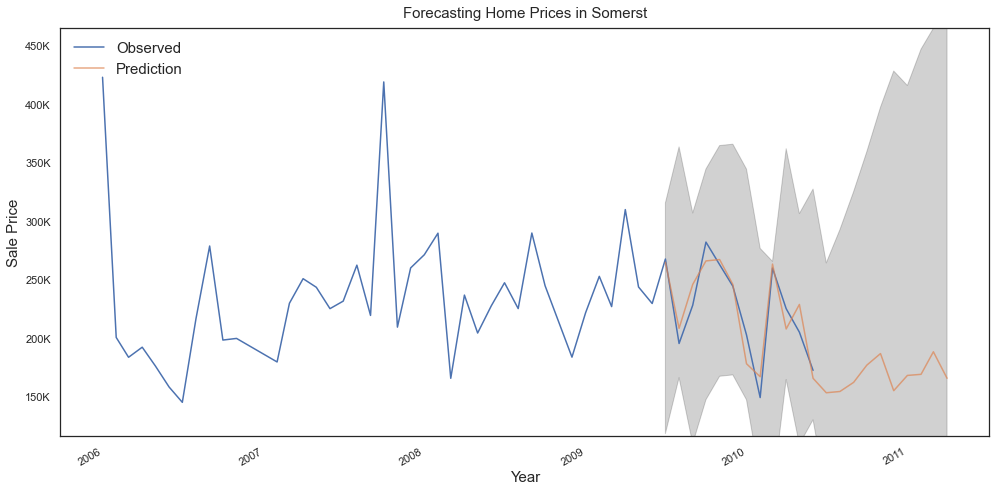

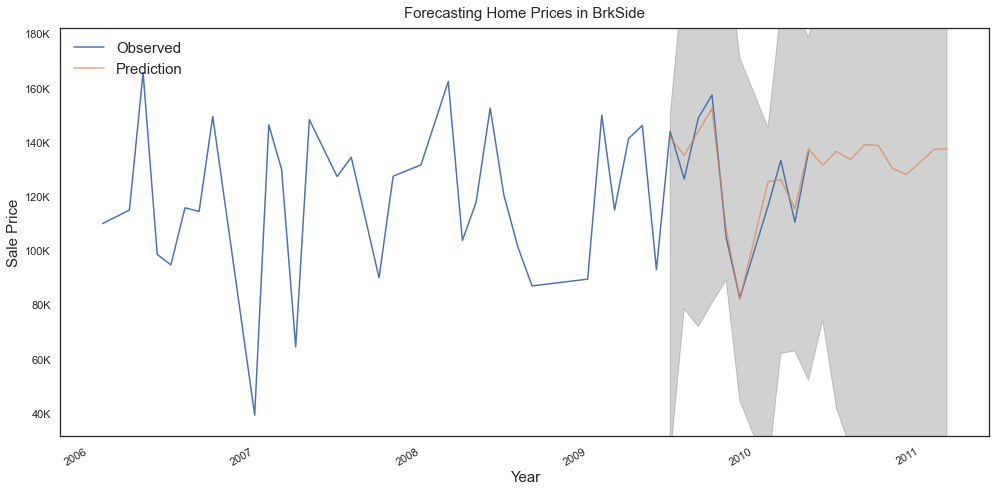

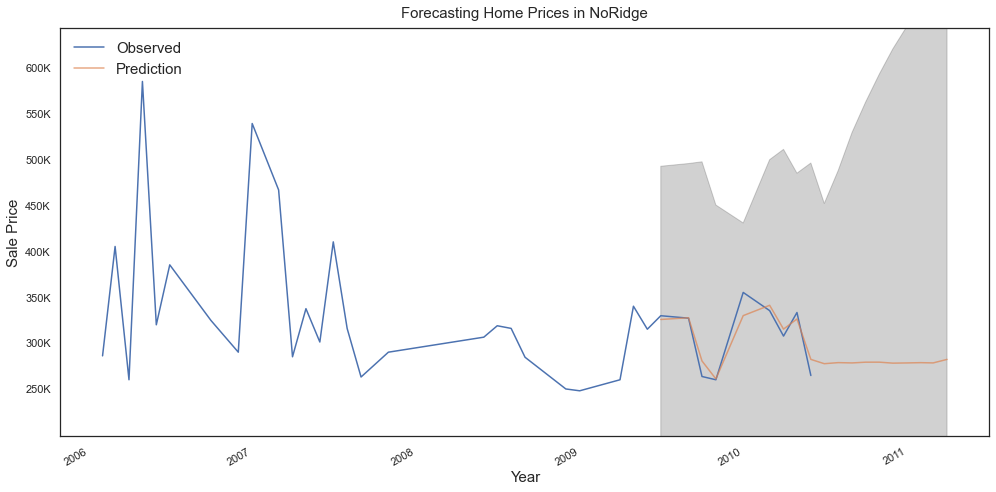

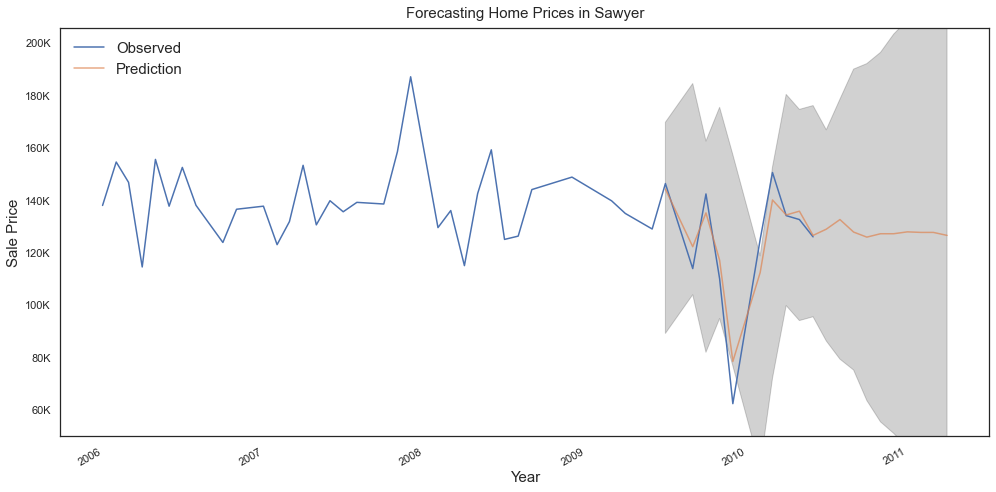

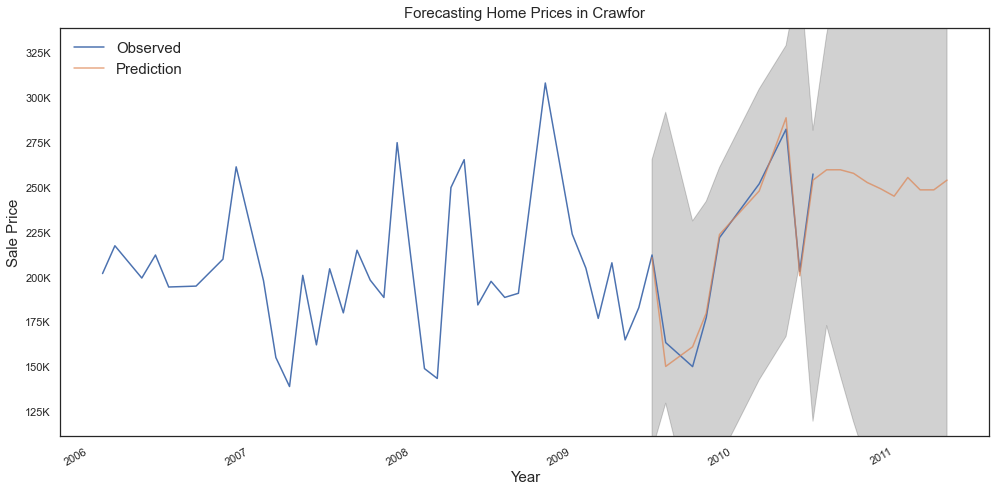

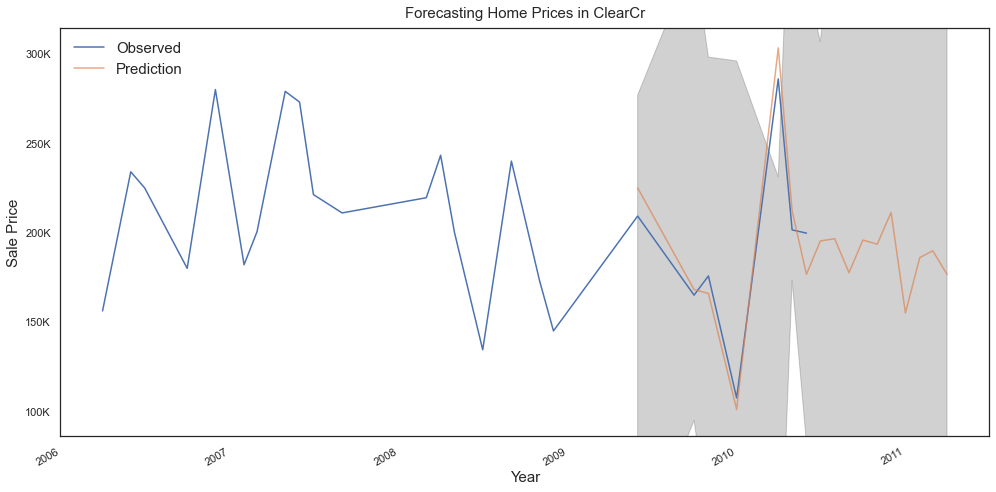

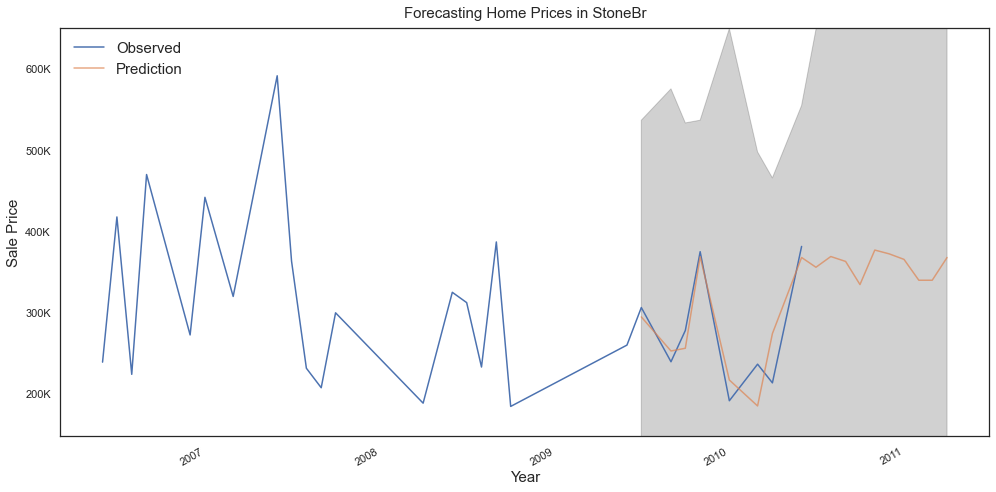

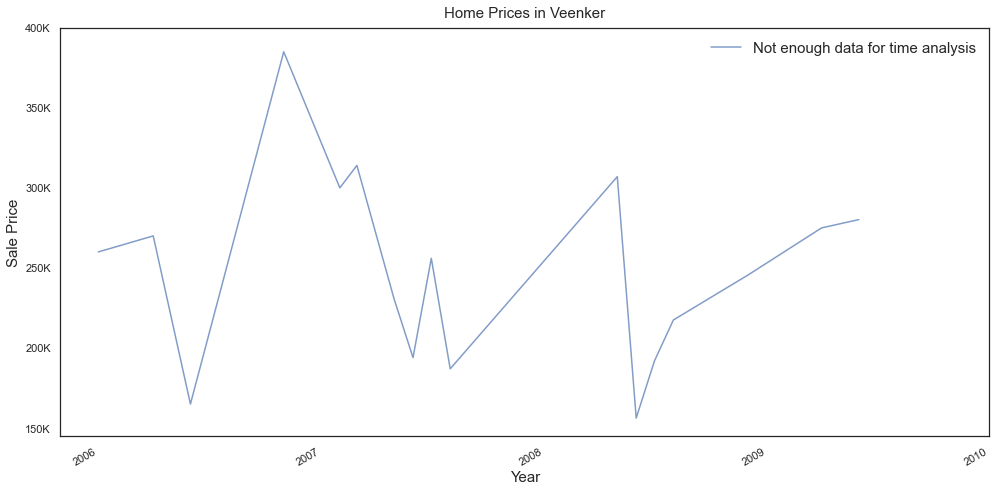

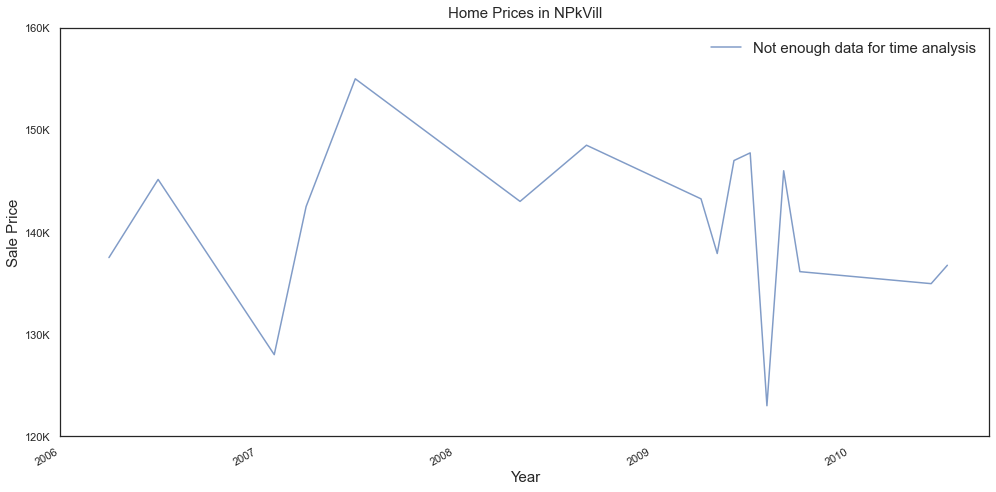

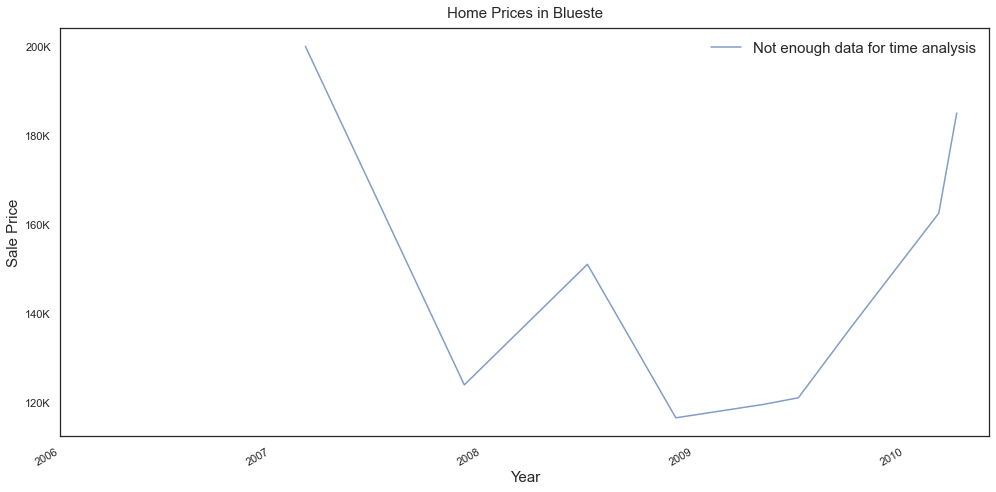

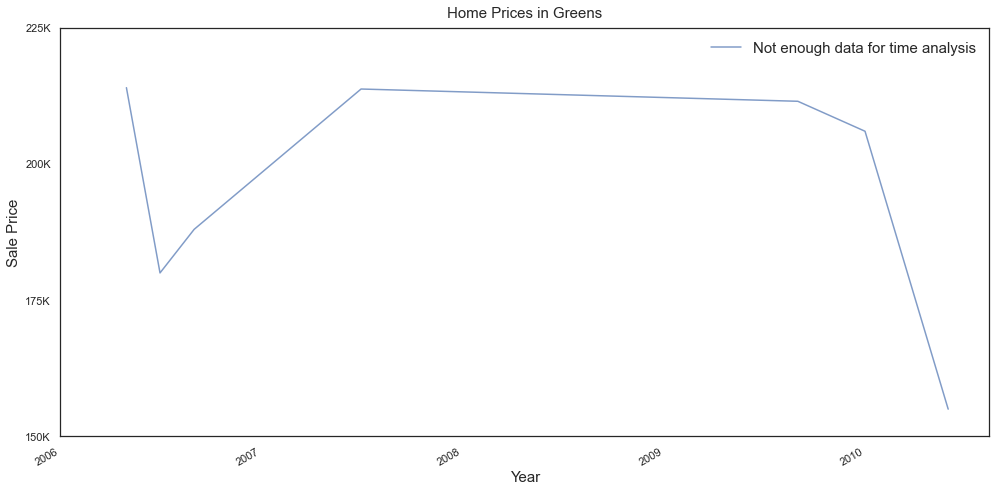

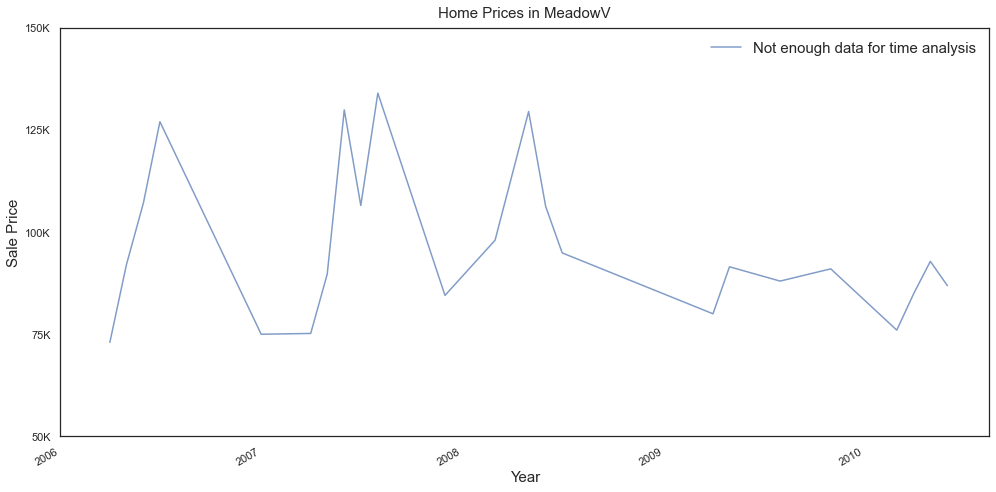

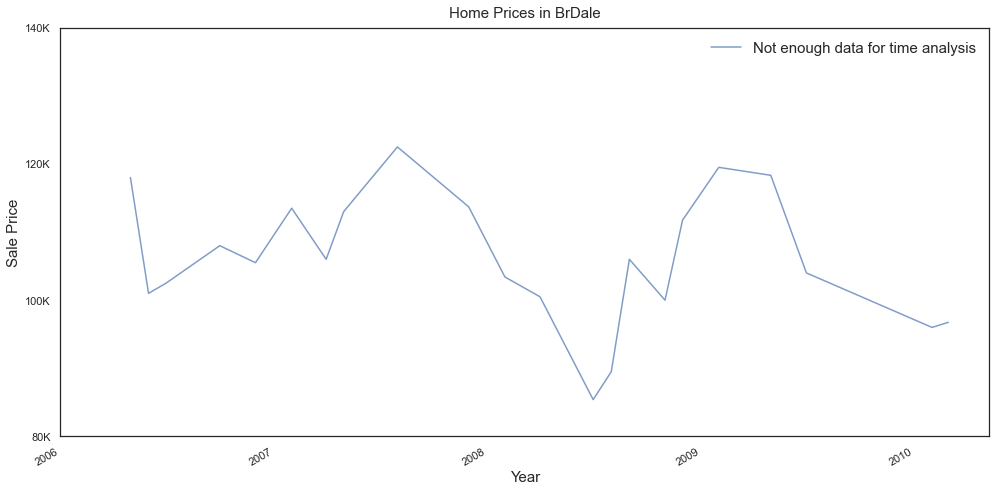

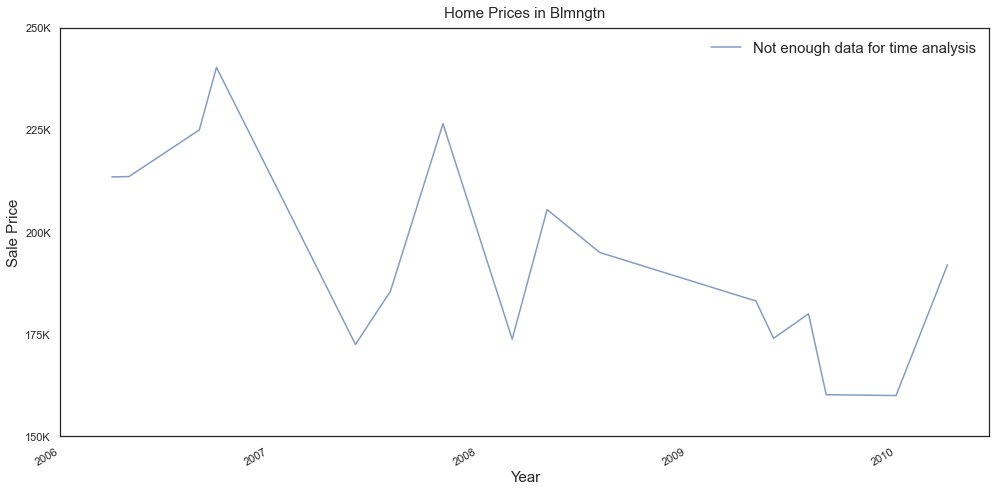

In [626]:
for neighborhood in neighborhoods:
    housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
    housing = housing[housing['Neighborhood'] == neighborhood]
    DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                            housing['MoSold'].astype(str) + '-1').rename('DateSold')

    df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
    df.rename(columns={'SalePrice': 'Observed'}, inplace=True)


    mod = sm.tsa.statespace.SARIMAX(df,
                                    order=neighborhood_params[neighborhood][0],
                                    seasonal_order=neighborhood_params[neighborhood][1],
                                    enforce_stationarity=neighborhood_params[neighborhood][2],
                                    enforce_invertibility=neighborhood_params[neighborhood][3])
    result = mod.fit(disp=False)

    predict = result.get_prediction(start=pd.to_datetime(neighborhood_params[neighborhood][4]), dynamic=False)
    forecast = result.get_forecast(steps=10)

    forecast_dates = pd.date_range(predict.predicted_mean.index[len(predict.predicted_mean)-1], 
                      freq='MS', periods=len(forecast.predicted_mean)).shift(1)

    ci = predict.conf_int().append(forecast.conf_int().set_axis(forecast_dates))
    pred = predict.predicted_mean.append(forecast.predicted_mean.set_axis(forecast_dates))
    fig = df.plot(label='Observed')

    predicted_mean = pred.shift(-1)
    predicted_mean.iloc[len(predicted_mean)-1] = result.forecast(1)
    predicted_mean.plot(ax=fig, label='Prediction', alpha=.7, figsize=(14, 7))

    fig.fill_between(ci.index,
                    ci.iloc[:, 0],
                    ci.iloc[:, 1], color='k', alpha=.2)

    fig.set(ylim = (min(df['Observed']) - 0.2*min(df['Observed']), 
                    max(df['Observed']) + 0.1*max(df['Observed'])),
            yticks = neighborhood_params[neighborhood][5],
            yticklabels = neighborhood_params[neighborhood][6])

    plt.title(f'Forecasting Home Prices in {neighborhood}', fontsize = 15, pad=10)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Sale Price', fontsize = 15)
    plt.legend(frameon=False, prop={'size': 15}, loc='upper left')
    plt.tight_layout()
    plt.savefig(f'./visualizations/{neighborhood}_sarima_prediction.png', dpi = 600)
    plt.show()
    
    
# for neighborhoods without enough data for time analysis
for neighborhood in not_enough_data:
    
    housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
    housing = housing[housing['Neighborhood'] == neighborhood]
    DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                            housing['MoSold'].astype(str) + '-1').rename('DateSold')

    df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
    label = 'Not enough data for time analysis'
    df.rename(columns={'SalePrice': label}, inplace=True)

    fig = df.plot(alpha=.7, figsize=(14, 7), label='Not enough data for time analysis')
    fig.set(xticks=['2006-01', '2007-01', '2008-01', '2009-01', '2010-01'],
            xticklabels=list(range(2006, 2011)),
            yticks=neighborhood_params[neighborhood][0],
            yticklabels=neighborhood_params[neighborhood][1])
    
    plt.title(f'Home Prices in {neighborhood}', fontsize = 15, pad = 10)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Sale Price', fontsize = 15)
    plt.legend(frameon=False, prop={'size': 15})
    plt.tight_layout()
    plt.savefig(f'./visualizations/{neighborhood}_sarima_prediction.png', dpi = 600)
    plt.show()

In [544]:
# #### GRID SEARCH

# for param in pdq:
#     for sparam in seasonal_pdq:
#         for stationarity in [True,False]:
#             for invertibility in [True, False]:
#                 try:
#                     mod = sm.tsa.statespace.SARIMAX(df,
#                                                     order=param,
#                                                     seasonal_order=sparam,
#                                                     enforce_stationarity=stationarity,
#                                                     enforce_invertibility=invertibility)
#                     result = mod.fit(disp=False)

#                     predict = result.get_prediction(start=pd.to_datetime('2009-06-01'), dynamic=False)
#                     forecast = result.get_forecast(steps=10)

#                     forecast_dates = pd.date_range(predict.predicted_mean.index[len(predict.predicted_mean)-1], 
#                                       freq='MS', periods=len(forecast.predicted_mean)).shift(1)

#                     ci = predict.conf_int().append(forecast.conf_int().set_axis(forecast_dates))
#                     pred = predict.predicted_mean.append(forecast.predicted_mean.set_axis(forecast_dates))
#                     fig = df.plot(label='Observed')

#                     predicted_mean = pred.shift(-1)
#                     predicted_mean.iloc[len(predicted_mean)-1] = result.forecast(1)
#                     predicted_mean.plot(ax=fig, label='Prediction', alpha=.7, figsize=(14, 7))

#                     fig.fill_between(ci.index,
#                                     ci.iloc[:, 0],
#                                     ci.iloc[:, 1], color='k', alpha=.2)

#                     fig.set(xlabel = 'Year', ylabel = 'Sale Price',
#                              ylim = (min(df['Observed']) - 0.1*min(df['Observed']), 
#                                      max(df['Observed']) + 0.1*max(df['Observed'])))

#                     plt.title(f'Forecasting Home Prices in {neighborhood}', fontsize = 15, pad=10)
#                     plt.legend()
#                     plt.tight_layout()
#                     plt.show()
#                     print(param, sparam, stationarity, invertibility, result.aic)
                    
#                 except:
#                     pass

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

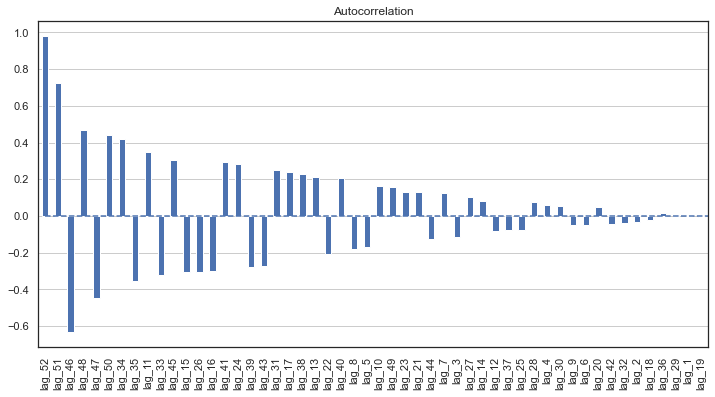

In [114]:

# auto_cor = sales.groupby("Date")["Weekly_Sales"].sum()
# auto_cor = pd.DataFrame(auto_cor)
# auto_cor.columns = ["y"]

df2 = df.copy()
# Adding the lag of the target variable from 1 steps back up to 52 (due to a seasonality at the end of the year)
for i in range(1, 53):
    df2["lag_{}".format(i)] = df2.SalePrice.shift(i)

# Compute autocorrelation of the series and its lags
lag_corr = df2.corr()
lag_corr = lag_corr.iloc[1:,0]
lag_corr.columns = ["corr"]
order = lag_corr.abs().sort_values(ascending = False)
lag_corr = lag_corr[order.index]

# Plot the Autocorrelation
plt.figure(figsize=(12, 6))
lag_corr.plot(kind='bar')
plt.grid(True, axis='y')
plt.title("Autocorrelation")
plt.hlines(y=0, xmin=0, xmax=len(lag_corr), linestyles='dashed')

In [107]:
import pmdarima as pm

In [122]:
stepwise_model = pm.auto_arima(df.iloc[:].values, start_p=1, start_q=1,
                               max_p=20, max_q=20, m=52,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=54.90 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=46.491, Time=2.17 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=35.91 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=20.54 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=5.26 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=4.21 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=46.911, Time=26.37 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=47.931, Time=1.18 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=48.884, Time=0.94 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=48.086, Time=15.16 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=46.411, Time=0.44 sec
 ARIMA(0,1,0)(1,1,0)[52] intercept   : AIC=48.145, Time=7.01 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(0,1,0)(1,1,1)[52] intercept   : AIC=49.778, Time=6.70 sec
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=49.931, Time=1.06